# Random-Forests in Scikit-Learn

For this example we will be using the [diamonds dataset](http://docs.ggplot2.org/0.9.3.1/diamonds.html) to demonstrate using [Scikit-Learn's Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (dealing with classification is similar).

In [1]:
# First let's import the packages we'll need
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Set style options
plt.style.use('ggplot')

In [2]:
# Read in diamonds dataset
# See http://docs.ggplot2.org/0.9.3.1/diamonds.html for more info
df = pd.read_csv('./data/diamonds.csv')

# Get dummies of some categorical columns
df = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 24 columns):
carat            53940 non-null float64
depth            53940 non-null float64
table            53940 non-null float64
price            53940 non-null int64
x                53940 non-null float64
y                53940 non-null float64
z                53940 non-null float64
cut_Good         53940 non-null float64
cut_Ideal        53940 non-null float64
cut_Premium      53940 non-null float64
cut_Very Good    53940 non-null float64
color_E          53940 non-null float64
color_F          53940 non-null float64
color_G          53940 non-null float64
color_H          53940 non-null float64
color_I          53940 non-null float64
color_J          53940 non-null float64
clarity_IF       53940 non-null float64
clarity_SI1      53940 non-null float64
clarity_SI2      53940 non-null float64
clarity_VS1      53940 non-null float64
clarity_VS2      53940 non-null float64
clarity_VVS1 

In [4]:
df.describe()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,...,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734,0.090953,0.399537,0.255673,...,0.153949,0.100519,0.052058,0.033185,0.242214,0.170449,0.151483,0.227253,0.067760,0.093919
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699,0.287545,0.489808,0.436243,...,0.360903,0.300694,0.222146,0.179121,0.428427,0.376030,0.358522,0.419061,0.251337,0.291719
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Importances

Let's first look at a graph using the built in Scikit-Learn feature importance attribute.  For convience, the function `feature_importance` will create our feature importance plot for us...

In [5]:
def feature_importance(rf, col_labels=None, importances=None, err=True):
    if isinstance(importances, type(None)):
        importances = rf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    idxs = np.argsort(importances)[::-1]

    if isinstance(col_labels, type(None)):
        col_labels = {}
    else:
        col_labels = {idx: label for idx, label in enumerate(col_labels)}

    # Print the ranking
    print('Feature ranking:')
    for feat in range(importances.shape[0]):
        print("{}. {} ({})".format(feat+1, col_labels.get(idxs[feat], idxs[feat]), importances[idxs[feat]]))

    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    if err:
        plt.bar(range(importances.shape[0]), importances[idxs], yerr=std[idxs], align='center')
    else:
        plt.bar(range(importances.shape[0]), importances[idxs], align='center')
    xticks = [col_labels.get(idx, idx) for idx in idxs]
    plt.xticks(range(importances.shape[0]), xticks, rotation=-45)
    plt.xlim([-1, importances.shape[0]])
    plt.tight_layout()

Feature ranking:
1. carat (0.618561360826)
2. y (0.269352579855)
3. clarity_SI2 (0.0194505226746)
4. clarity_SI1 (0.0139472217024)
5. color_J (0.0113181909223)
6. color_I (0.0085500398463)
7. color_H (0.00718807006449)
8. z (0.00601150437747)
9. depth (0.00585093471215)
10. x (0.00564108880239)
11. clarity_VS2 (0.00520856170556)
12. clarity_VVS2 (0.004993243633)
13. clarity_IF (0.00483114829743)
14. clarity_VVS1 (0.00466614781693)
15. clarity_VS1 (0.00407792018927)
16. color_G (0.00319833201969)
17. table (0.00302819875478)
18. color_F (0.00109482026955)
19. cut_Ideal (0.00102923266885)
20. color_E (0.000894832864822)
21. cut_Premium (0.000416274748709)
22. cut_Good (0.000386456490274)
23. cut_Very Good (0.000303316758249)


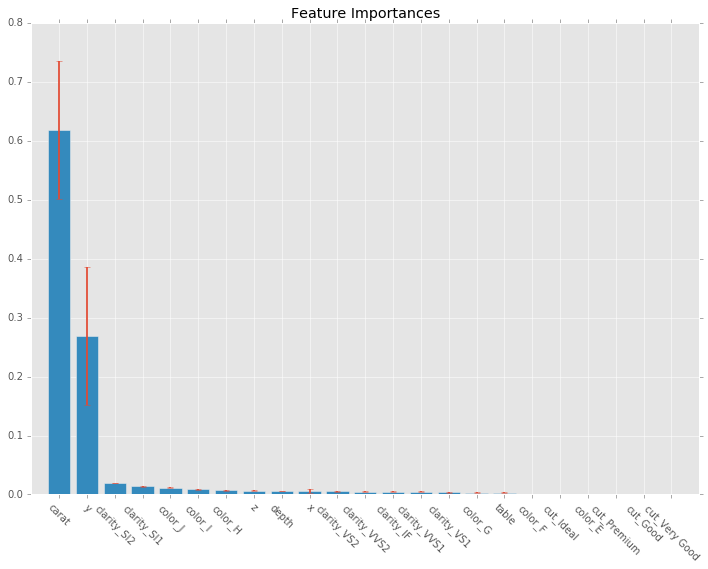

In [6]:
y = df.pop('price').values
X = df.values

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

feature_importance(rf, df.columns.tolist())

### Leave One Out Feature Importance

Let's compare this to a leave one out feature importance whereby we iteratively drop each feature from our model and compare the change in MSE from before and after that feature was removed.  If the feature isn't important the resulting change in MSE should be small.

In [7]:
def leave_one_out_feature_import(X, y, model, criterion=mean_squared_error, norm=True):
    ''' Drop each feature out and observe the effect on the specified criterion
    INPUT:
        X: numpy array
            Numpy array holding all features
        y: numpy array
            Numpy array of targets
        model: Model implementing .fit() and .predict()
        criterion: function evaluating a particular metric
            This function should be called like so: criterion(y_true, y_pred)
    OUTPUT:
        importances: numpy array
    '''
    model.fit(X, y)
    base = criterion(y, model.predict(X))
    importances = []

    for feat in range(X.shape[1]):
        X_sub = X[:, np.array([col != feat for col in range(X.shape[1])])]
        model.fit(X_sub, y)
        importances.append(abs(base - criterion(y, model.predict(X_sub))))

    importances = np.array(importances)
    if norm:
        importances = importances / np.sum(importances)
    return importances

Feature ranking:
1. color_J (0.154859238191)
2. color_I (0.118499882631)
3. clarity_VS1 (0.100736963509)
4. clarity_VS2 (0.0938223964663)
5. clarity_VVS2 (0.0925021264022)
6. clarity_VVS1 (0.0891325398241)
7. clarity_IF (0.0869917985206)
8. color_H (0.0860718320484)
9. color_G (0.0486975504867)
10. clarity_SI1 (0.047449317829)
11. carat (0.0196462434719)
12. color_F (0.0180931343938)
13. clarity_SI2 (0.0138746807024)
14. cut_Very Good (0.00471763294253)
15. y (0.00464188667718)
16. cut_Good (0.00421003448687)
17. color_E (0.00389561517461)
18. x (0.00336246285797)
19. table (0.00255238961453)
20. depth (0.0025161815981)
21. cut_Ideal (0.00198161944995)
22. z (0.00142923691308)
23. cut_Premium (0.000315235808528)


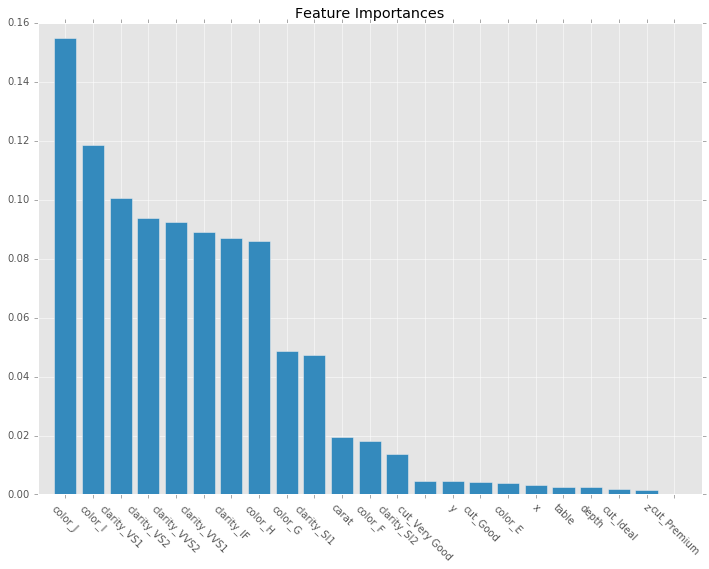

In [8]:
loo_importance = leave_one_out_feature_import(X, y, rf)
feature_importance(rf, df.columns.tolist(), importances=loo_importance, err=False)

Why are these estimations of importance so different?  One possible explaination is that features that were deemed to be important in our initial feature importance plot can be represented by other features in our dataset.  For example, `carat` (a measure of weight) can likely be accurately represented by `x`, `y`, `z` (length, width, and depth respectively).

This also points out a crucial nuance to Scikit-Learn's measure of feature importance: continuous features often are deemed more important than categorical ones.  This is due to the fact that a features importance are calculated by measuring the total decrease in node impurity (weighted by the probability of reaching that node) averaged over all trees of the ensemble.  A boolean feature can only be split on once in a given tree whereas a continous feature can be split on multiple times.

Indeed, if you drop both `carat` and `y`, continous features `x` and `z` move up to be the most important features by sklearn's measure.

### Permuted Feature Importance

A similar approach to dropping an entire column is to instead permute that column.  This would give you a sense of how your model would be effected by replacing a feature with random noise.  If the feature truly wasn't important, permuting it wouldn't effect the resulting MSE.

The result is very similar to our previous approach...

In [9]:
def permuted_feature_import(X, y, model, criterion=mean_squared_error, norm=True):
    ''' Drop each feature out and observe the effect on the specified criterion
    INPUT:
        X: numpy array
            Numpy array holding all features
        y: numpy array
            Numpy array of targets
        model: Model implementing .fit() and .predict()
        criterion: function evaluating a particular metric
            This function should be called like so: criterion(y_true, y_pred)
    OUTPUT:
        importances: numpy array
    '''
    model.fit(X, y)
    base = criterion(y, model.predict(X))
    importances = []

    for feat in range(X.shape[1]):
        Xc = np.copy(X)
        np.random.shuffle(Xc[:, feat])
        model.fit(Xc, y)
        importances.append(abs(base - criterion(y, model.predict(Xc))))

    importances = np.array(importances)
    if norm:
        importances = importances / np.sum(importances)
    return importances

Feature ranking:
1. color_J (0.145052409101)
2. color_I (0.120642284059)
3. clarity_VVS2 (0.100625915161)
4. clarity_VS2 (0.090941643857)
5. clarity_VS1 (0.0878452307219)
6. clarity_IF (0.0857274222348)
7. clarity_VVS1 (0.0845622020999)
8. color_H (0.083763322616)
9. clarity_SI1 (0.0530575255619)
10. color_G (0.0464863582451)
11. carat (0.0211355044577)
12. color_F (0.0144683637957)
13. clarity_SI2 (0.0132474328562)
14. z (0.0131600651053)
15. depth (0.0110022743216)
16. table (0.00819853837838)
17. x (0.0072347233763)
18. color_E (0.0033848007809)
19. cut_Ideal (0.00281533285779)
20. cut_Very Good (0.00224790672323)
21. cut_Good (0.00219751709702)
22. y (0.0020674707975)
23. cut_Premium (0.000135755795236)


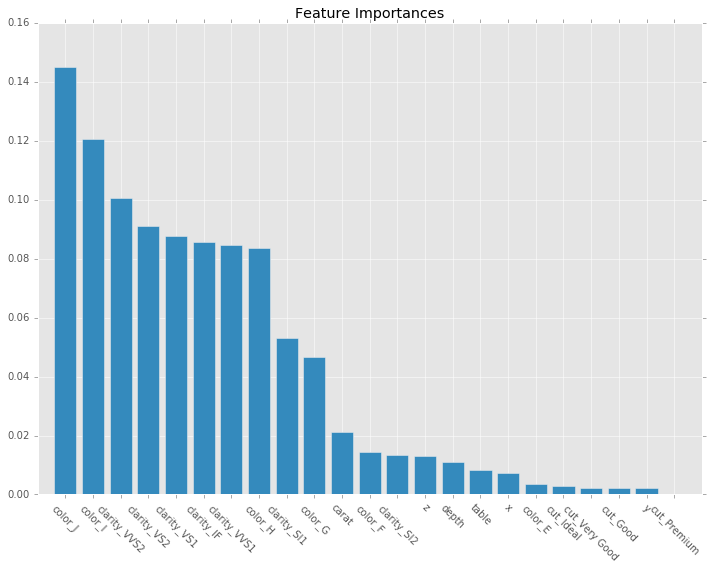

In [10]:
permute_importance = permuted_feature_import(X, y, rf)
feature_importance(rf, df.columns.tolist(), importances=permute_importance, err=False)

### Interpreting our Forest

We can use the package `treeinterpreter` to get a sense for how each feature is changing our prediction for a given data point...

In [ ]:
# pip install tree interpreter
from treeinterpreter import treeinterpreter as ti

rf.fit(X, y)

# Get feature contributions
prediction, bias, contributions = ti.predict(rf, X)
df_contrib = pd.DataFrame(contributions, columns=df.columns.tolist())
df_contrib['bias'] = bias
df_contrib['prediction'] = prediction

# First plot a scatter of caret vs. y
df.plot('carat', 'y', kind='scatter')

In [ ]:
# Plot feature contributions for top two variables
df_contrib.plot('carat', 'y', kind='scatter')

## Partial Dependency Plots

In [ ]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence